In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [2]:
# Load dataset
df = pd.read_csv('../../data/data.csv')

X = df.drop(columns=['Country', 'Region', 'Year', 'Life_expectancy'])
y = df['Life_expectancy']

# Drop 'Infant_deaths' due to high VIF with 'Under_five_deaths'
X.drop(columns=['Infant_deaths'], inplace=True)

# Rename 'Economy_Status_developed' to 'Economy_status'
X.rename(columns={'Economy_status_Developed': 'Economy_status'}, inplace=True)
# Drop 'Economy_Status_Developing' due to high VIF with 'Economy_status'
X.drop(columns=['Economy_status_Developing'], inplace=True)

# Combine Vaccination features into a single feature
X['Vaccination_Polio_Diphteria_Hepatitis_B'] = X['Polio'] + X['Diphtheria'] + X['Hepatitis_B']
X.drop(columns=['Polio', 'Diphtheria', 'Hepatitis_B'], inplace=True)

# Combine Thinness features into a single feature
X['Thinness'] = X['Thinness_ten_nineteen_years'] + X['Thinness_five_nine_years']
X.drop(columns=['Thinness_ten_nineteen_years', 'Thinness_five_nine_years'], inplace=True)

# Combine Mortality features into a single feature
X['Mortality'] = X['Under_five_deaths'] + X['Adult_mortality']
X.drop(columns=['Under_five_deaths', 'Adult_mortality'], inplace=True)

# Apply Binning Balancing

In [3]:
# Bin 'Life_expectancy' into intervals of 5 years from 40 to 85
bins = np.arange(40, 90, 5)
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins) - 1)]
df['Life_expectancy_bin'] = pd.cut(df['Life_expectancy'], bins=bins, labels=bin_labels, right=False)

# Encode categorical variables using LabelEncoder
label_encoders = {}
encoded_df = df.copy()
for col in encoded_df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col])
    label_encoders[col] = le

# Define features and target variable
X = encoded_df.drop(columns=['Life_expectancy', 'Life_expectancy_bin'])
y_binned = encoded_df['Life_expectancy_bin']  # Binned target for SMOTE
y_continuous = encoded_df['Life_expectancy']  # Continuous target for regression

# Drop rows with missing target labels
X = X[y_binned.notnull()]
y_binned = y_binned[y_binned.notnull()]
y_continuous = y_continuous[y_binned.index]

# Encode binned target for SMOTE
y_binned_encoded = y_binned.astype('category').cat.codes

# Split data into training and testing sets
X_train_binned, X_test_binned, y_train_binned, y_test_binned = train_test_split(X, y_binned_encoded, test_size=0.2, random_state=1)
_, _, y_train_continuous, y_test_continuous = train_test_split(
    X, y_continuous, test_size=0.2, random_state=1
)

# Apply SMOTE to the training data
smote = SMOTE(random_state=1)
X_resampled, y_resampled_binned = smote.fit_resample(X_train_binned, y_train_binned)

# Map resampled binned target back to continuous target values
y_resampled_continuous = pd.Series(y_resampled_binned).map(
    dict(zip(range(len(bin_labels)), bins[:-1] + 2.5))
)
y_resampled_continuous = y_resampled_continuous.astype(float)

# Scale the resampled training data and original test data
scaler = StandardScaler()
X_train_scaled_binned = scaler.fit_transform(X_resampled)
X_test_scaled_binned = scaler.transform(X_test_binned)


# Train and evaluate Random Forest Regressor

In [4]:
# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled_binned, y_resampled_continuous)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled_binned)

# Calculate error metrics
mae_rf = mean_absolute_error(y_test_continuous, y_pred_rf)
mse_rf = mean_squared_error(y_test_continuous, y_pred_rf)
r2_rf = r2_score(y_test_continuous, y_pred_rf)

# Print the evaluation metrics
print("Random Forest Regression Results on Original Scale:")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")

Random Forest Regression Results on Original Scale:
Mean Absolute Error (MAE): 0.9716
Mean Squared Error (MSE): 1.3043
R² Score: 0.9840


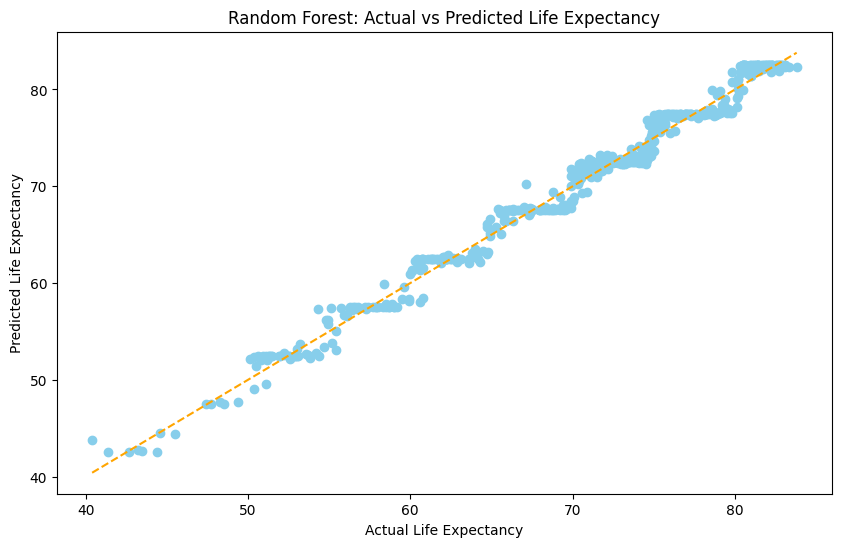

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_continuous, y_pred_rf, color='skyblue')
plt.plot([y_test_continuous.min(), y_test_continuous.max()], [y_test_continuous.min(), y_test_continuous.max()], linestyle='--', color='orange')
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Random Forest: Actual vs Predicted Life Expectancy")
plt.show()

# Train and evaluate Linear Regression

In [6]:
# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled_binned, y_resampled_continuous)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_scaled_binned)

# Recalculate the error metrics using the inverse-transformed values
mae_lr = mean_absolute_error(y_test_continuous, y_pred_lr)
mse_lr = mean_squared_error(y_test_continuous, y_pred_lr)
r2_lr = r2_score(y_test_continuous, y_pred_lr)

# Print the recalculated evaluation metrics
print("Linear Regression Results on Original Scale:")
print(f"Mean Absolute Error (MAE): {mae_lr:.4f}")
print(f"Mean Squared Error (MSE): {mse_lr:.4f}")
print(f"R² Score: {r2_lr:.4f}")

Linear Regression Results on Original Scale:
Mean Absolute Error (MAE): 1.1708
Mean Squared Error (MSE): 2.1049
R² Score: 0.9742


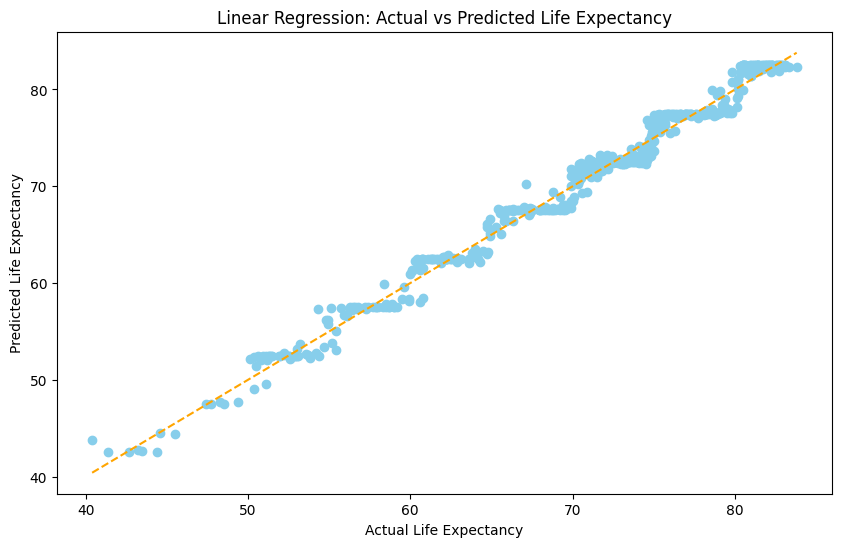

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_continuous, y_pred_rf, color='skyblue')
plt.plot([y_test_continuous.min(), y_test_continuous.max()], [y_test_continuous.min(), y_test_continuous.max()], linestyle='--', color='orange')
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Linear Regression: Actual vs Predicted Life Expectancy")
plt.show()

# Train and evaluate K-Nearest Neighbors Regressor
## Find the optimal number of neighbors

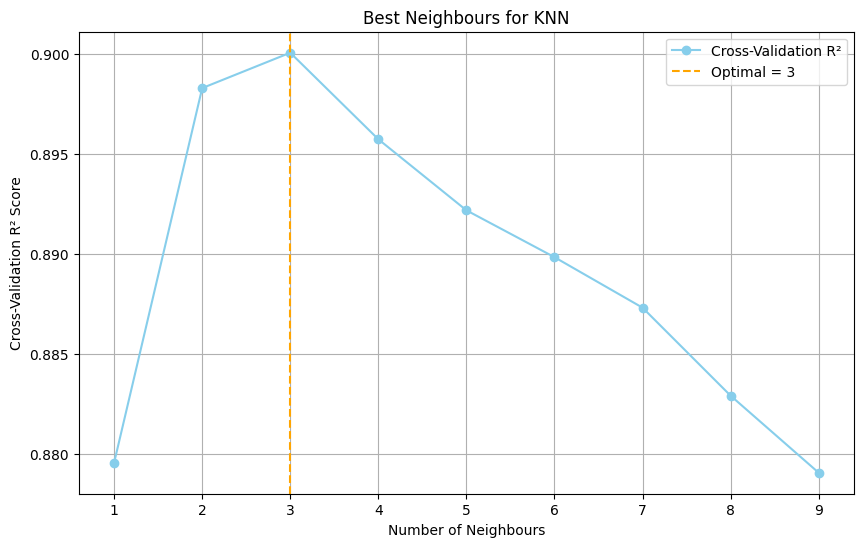

In [8]:
# Initialize the figure
fig, (ax1) = plt.subplots(1, figsize=(10, 6))

# First: Evaluate and plot for transformed data
neighbor_range = range(1, 10)
cv_scores_transformed = []

for n in neighbor_range:
    knn = KNeighborsRegressor(n_neighbors=n)
    scores = cross_val_score(knn, X_train_binned, y_train_binned, cv=5, scoring='r2')
    cv_scores_transformed.append(scores.mean())

best_n_neighbors_transformed = neighbor_range[np.argmax(cv_scores_transformed)]

# Plot for transformed data
ax1.plot(neighbor_range, cv_scores_transformed, marker='o', linestyle='-', color='skyblue', label="Cross-Validation R²")
ax1.axvline(best_n_neighbors_transformed, color='orange', linestyle='--',
            label=f"Optimal = {best_n_neighbors_transformed}")
ax1.set_title("Best Neighbours for KNN")
ax1.set_xlabel("Number of Neighbours")
ax1.set_ylabel("Cross-Validation R² Score")
ax1.legend()
ax1.grid()

plt.show()

## Train and evaluate K-Nearest Neighbors Regressor with the optimal number of neighbors

In [9]:
# Initialize and train the KNN Regressor
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train_scaled_binned, y_resampled_continuous)

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test_scaled_binned)

# Recalculate the error metrics using the inverse-transformed values
mae_knn = mean_absolute_error(y_test_continuous, y_pred_knn)
mse_knn = mean_squared_error(y_test_continuous, y_pred_knn)
r2_knn = r2_score(y_test_continuous, y_pred_knn)

# Print the recalculated evaluation metrics
print("KNN Regression Results on Original Scale:")
print(f"Mean Absolute Error (MAE): {mae_knn:.4f}")
print(f"Mean Squared Error (MSE): {mse_knn:.4f}")
print(f"R² Score: {r2_knn:.4f}")

KNN Regression Results on Original Scale:
Mean Absolute Error (MAE): 1.1215
Mean Squared Error (MSE): 1.8104
R² Score: 0.9778


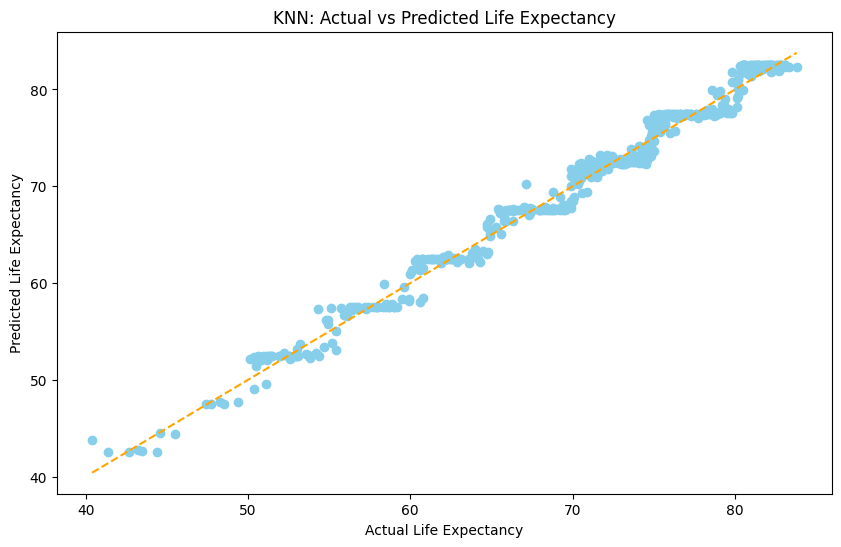

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_continuous, y_pred_rf, color='skyblue')
plt.plot([y_test_continuous.min(), y_test_continuous.max()], [y_test_continuous.min(), y_test_continuous.max()], linestyle='--', color='orange')
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("KNN: Actual vs Predicted Life Expectancy")
plt.show()